### Load data

In [ ]:
!unzip '/content/drive/MyDrive/colab/subex/Subex Hackathon Dataset.zip'

In [ ]:
import os
from pathlib import Path
import xml.etree.ElementTree as ET
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2 as cv
import numpy as np
import os
import shutil

In [ ]:
images_path = Path('/content/Subex Hackathon Dataset/images')
labels_path = Path('/content/Subex Hackathon Dataset/labels')

In [ ]:
image_names = sorted(os.listdir(images_path))
label_names = sorted(os.listdir(labels_path))
n_images = len(image_names)
n_labels = len(label_names)

In [ ]:
n_images, n_labels

In [ ]:
Counter(list(map(lambda s: s.split('.')[1], image_names)))

In [ ]:
def read_image(path):
  return cv.imread(str(path))[..., ::-1]

In [ ]:
xs = []
ys = []
cs = []
for image_name in image_names:
  path = images_path / image_name
  shape = read_image(path).shape
  xs.append(shape[0])
  ys.append(shape[1])
  cs.append(shape[2])

In [ ]:
Counter(cs)

In [ ]:
np.mean(xs), np.std(xs)

In [ ]:
np.mean(ys), np.std(ys)

In [ ]:
label_names = os.listdir(labels_path)

In [ ]:
n = 8
# read labels (xml)
label = tree = ET.parse(str(labels_path / label_names[n]))
root = tree.getroot()

In [ ]:
def get_yolo_coords(label_name, image_w, image_h):
  tree = ET.parse(str(labels_path / label_name))
  root = tree.getroot()
  
  objects = []
  for child in root:
    if child.tag == 'object':
      objects.append(child)

  bboxes = []
  for object in objects:
    for child in object:
      if child.tag == 'bndbox':
        bboxes.append(child)

  coords = []
  for bbox in bboxes:
    coord = []
    for child in bbox:
      coord.append(int(child.text))
    x, y, x_, y_ = coord
    w = x_ - x  # width
    h = y_ - y  # height
    x = (x + x_) / 2  # mid-point
    y = (y + y_) / 2  # mid-point
    
    # normalize eveything as Yolo expects in that way
    x = x / image_w
    y = y / image_h
    w = w / image_w
    h = h / image_h
    coord = x, y, w, h
    coords.append(coord)

  return coords      

In [ ]:
def visualize_data(image_name, yolo_coords, image_w, image_h):
  image = read_image(images_path / image_name)
  image_h, image_w = image.shape[:2]
  coords = []
  for yolo_coord in yolo_coords:
    a, b, c, d = yolo_coord
    w = c * image_w
    h = d * image_h
    x = ((2*a*image_w) - w)/2
    y = ((2*b*image_h) - h)/2
    coord = [x, y, w, h]
    coord = list(map(int, coord))
    coords.append(coord)
  
  fig, ax = plt.subplots(1)
  for coord in coords:
    x, y, w, h = coord
    rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
  ax.imshow(image);

In [ ]:
def get_label_name(image_name):
  return image_name.split('.')[0] + '.xml'

In [ ]:
for image_name in image_names[-1: -6: -1]:
  label_name = get_label_name(image_name)
  image = read_image(images_path / image_name)
  image_h, image_w = image.shape[:2]
  yolo_coords = get_yolo_coords(label_name, image_w, image_h)
  visualize_data(image_name, yolo_coords, image_w, image_h)

### YOLO

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet
# !git clone https://github.com/utkarsh-21st/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 14691, done.
remote: Total 14691 (delta 0), reused 0 (delta 0), pack-reused 14691
Receiving objects: 100% (14691/14691), 13.27 MiB | 24.44 MiB/s, done.
Resolving deltas: 100% (9995/9995), done.


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
# make darknet (builds darknet so that you can then use the darknet executable file to run or train object detectors)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
  

In [ ]:
# # Download pre-trained YOLOv4 weights
# !wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

### Prepare data for YOLO

In [ ]:
yolo_path = Path('/content/drive/MyDrive/colab/subex/yolo4')
data_path = Path('/content/darknet/data')

In [ ]:
# # create yolo4 folder in drive
# if not yolo_path.exists():
#   os.mkdir(yolo_path)

# # create backup folder inside yolo4 folder (created above)
# if not (yolo_path / 'backup').exists():
#   os.mkdir(yolo_path / 'backup')

In [ ]:
# # write obj.data to drive
# if not (yolo_path / 'obj.data').exists():
#   with open(yolo_path / 'obj.data', 'w') as file:
#     file.write('classes = 1\ntrain = data/train.txt\nvalid = data/test.txt\nnames = data/obj.names\nbackup = /content/drive/MyDrive/colab/subex/yolo4/backup')

# # write obj.names to drive
# if not (yolo_path / 'obj.names').exists():
#   with open(yolo_path / 'obj.names', 'w') as file:
#     file.write('Table')

In [ ]:
# !rm -rf /content/darknet/data/obj

In [ ]:
# unzip obj and test to colab
shutil.unpack_archive(yolo_path / 'obj.zip', data_path / 'obj', 'zip')  
shutil.unpack_archive(yolo_path / 'test.zip', data_path / 'test', 'zip')  

In [ ]:
# # delete obj and test from drive
# !rm -rf /content/drive/MyDrive/colab/subex/yolo4/obj
# !rm -rf /content/drive/MyDrive/colab/subex/yolo4/test

# # delete obj and test from colab
# !rm -rf /content/darknet/data/obj
# !rm -rf /content/darknet/data/test

In [ ]:
# train_path = data_path / 'obj'
# val_path = data_path / 'test'

# os.mkdir(train_path)
# os.mkdir(val_path)

In [ ]:
# # move cfg file to drive and edit using text-editor
# if not Path(yolo_path / 'yolov4-obj.cfg').exists():
#   shutil.copy(data_path.parent / 'cfg/yolov4-custom.cfg', yolo_path / 'yolov4-obj.cfg')

In [ ]:
# fraction = 0.8
# n_train = int(n_images * fraction)
# n_val = n_images - n_train

In [ ]:
# np.random.seed(123)
# np.random.choice(n_images, n_train, replace=False)

In [ ]:
len(set(os.listdir('/content/darknet/data/test') + os.listdir('/content/darknet/data/obj')))/2

340.0

In [ ]:
# np.random.seed(123)
# train_idx = np.random.choice(n_images, n_train, replace=False)

# for idx in range(n_images):
#   image_name = image_names[idx]
#   name = image_name.split('.')[0]
#   image = read_image(images_path / image_name)
#   image_h, image_w = image.shape[:2]
#   label_name = name + '.xml'
#   yolo_coords = get_yolo_coords(label_name, image_w, image_h)

#   image_name = name + '.jpg'
#   if idx in train_idx:
#     for yolo_coord in yolo_coords: 
#       annot = '0' + ' ' + ' '.join(map(lambda c: str(round(c, 4)), yolo_coord))
#       with open(train_path / (name + '.txt'), 'a') as file:
#         file.write(annot + '\n')
#     cv.imwrite(str(train_path / image_name), image)
#   else:
#     for yolo_coord in yolo_coords: 
#       annot = '0' + ' ' + ' '.join(map(lambda c: str(round(c, 4)), yolo_coord))
#       with open(val_path / (name + '.txt'), 'a') as file:
#         file.write(annot + '\n')
#     cv.imwrite(str(val_path / image_name), image)

In [ ]:
# # zip obj and test to drive
# import shutil
# shutil.make_archive(yolo_path / 'obj', 'zip', data_path / 'obj')
# shutil.make_archive(yolo_path / 'test', 'zip', data_path / 'test')

In [ ]:
# cfg - copy from drive to data_path.parent
if not (data_path.parent / 'cfg/yolov4-obj.cfg').exists():
  shutil.copy(yolo_path / 'yolov4-obj.cfg', data_path.parent / 'cfg/yolov4-obj.cfg')

# obj.data - copy from drive to data_path
if not (data_path / 'obj.data').exists():
  shutil.copy(yolo_path / 'obj.data', data_path / 'obj.data')

# obj.names - copy from drive to data_path.parent
if not (data_path.parent / 'obj.names').exists():
  shutil.copy(yolo_path / 'obj.names', data_path / 'obj.names')

# generate_train.py - copy from drive to data_path.parent
if not (data_path.parent / 'generate_train.py').exists():
  shutil.copy(yolo_path / 'generate_train.py', data_path.parent / 'generate_train.py')

# generate_test.py - copy from drive to data_path.parent
if not (data_path.parent / 'generate_test.py').exists():
  shutil.copy(yolo_path / 'generate_test.py', data_path.parent / 'generate_test.py')

In [ ]:
!python generate_train.py
!python generate_test.py

In [ ]:
# # download pretrained weights
# !wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [ ]:
# set subdivisions=32

In [ ]:
# # train your custom detector! (uncomment %%capture below if you run into memory issues or your Colab is crashing)
# # %%capture
# !./darknet detector train data/obj.data cfg/yolov4-obj.cfg yolov4.conv.137 -dont_show -map

In [ ]:
# check charts and select the best model

In [ ]:
# kick off training from where it last saved
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg /content/drive/MyDrive/colab/subex/yolo4/backup/yolov4-obj_last.weights -dont_show

Streaming output truncated to the last 5000 lines.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.000000), count: 1, class_loss = 0.000004, iou_loss = 0.000000, total_loss = 0.000004 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.000000), count: 1, class_loss = 0.000006, iou_loss = 0.000000, total_loss = 0.000006 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.920419), count: 2, class_loss = 0.000105, iou_loss = 0.122962, total_loss = 0.123067 
 total_bbox = 302983, rewritten_bbox = 0.001650 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls:

In [ ]:
# 0.322 -> around 4800 iterations

In [ ]:
# Todo: compare best weights and last weight by score

### Results

In [ ]:
# # run darknet detection on test images
# !./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/person.jpg

In [ ]:
# define helper functions

def imShow(path):

  import cv2

  import matplotlib.pyplot as plt

  %matplotlib inline



  image = cv2.imread(path)

  height, width = image.shape[:2]

  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)



  fig = plt.gcf()

  fig.set_size_inches(18, 10)

  plt.axis("off")

  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))

  plt.show()

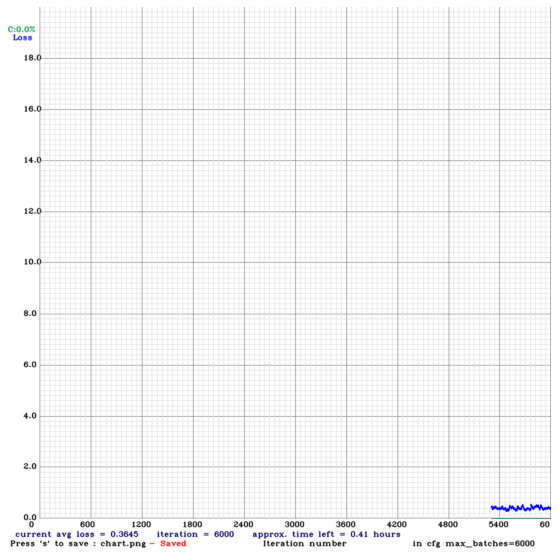

In [ ]:
# show chart.png of how custom object detector did with training
imShow('chart.png')

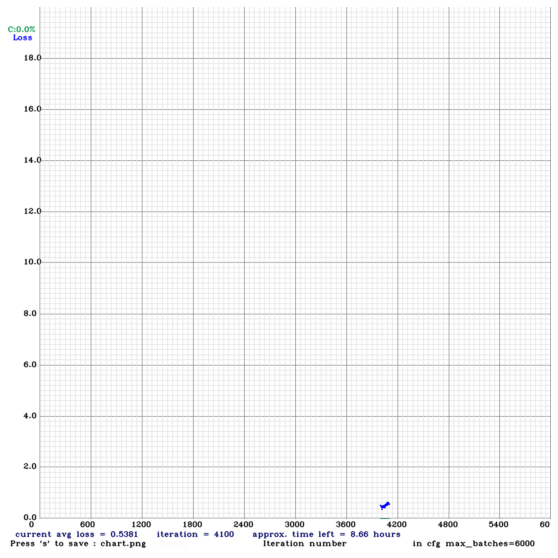

In [ ]:
# show chart.png of how custom object detector did with training
imShow('chart.png')

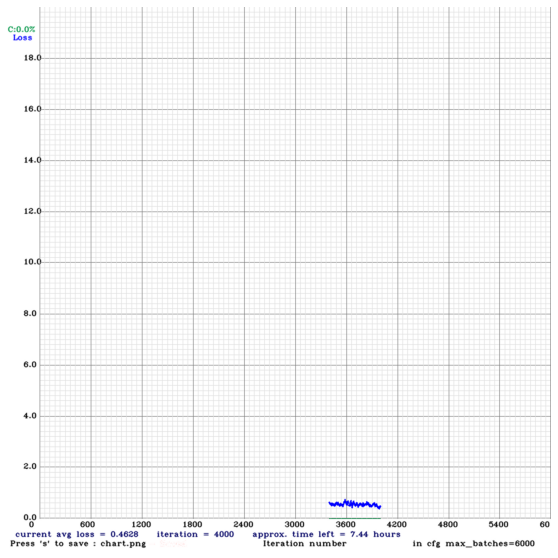

In [ ]:
# show chart.png of how custom object detector did with training
imShow('chart.png')

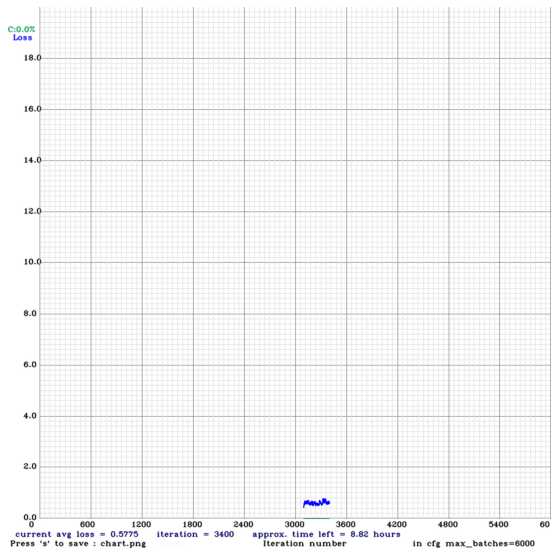

In [ ]:
# show chart.png of how custom object detector did with training
imShow('chart.png')

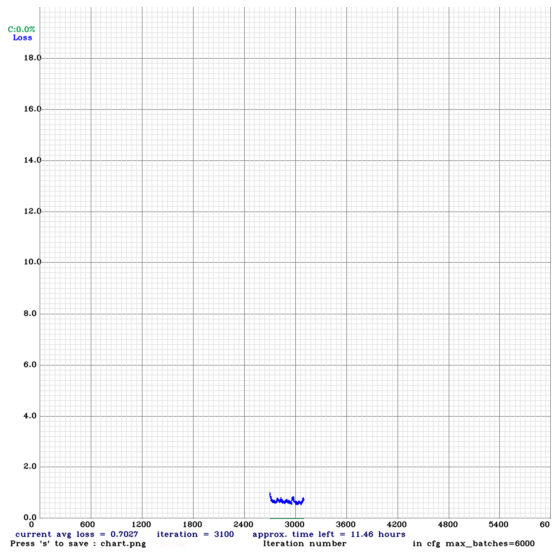

In [ ]:
# show chart.png of how custom object detector did with training
imShow('chart.png')

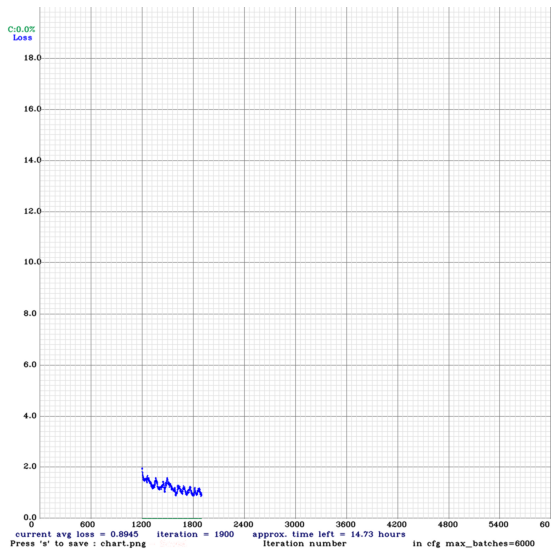

In [ ]:
# show chart.png of how custom object detector did with training
imShow('chart.png')

In [ ]:
name = '0.3371.weights'
shutil.copy(f'/content/drive/MyDrive/colab/subex/yolo4/backup/{name}', f'/content/darknet/{name}')

'/content/darknet/0.3371.weights'

In [ ]:
# score - 0.3371 weights
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg /content/darknet/0.3371.weights

 CUDA-version: 10010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 32, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 

In [ ]:
name = 'yolov4-obj_last.weights'
shutil.copy(f'/content/drive/MyDrive/colab/subex/yolo4/backup/{name}', f'/content/darknet/{name}')

'/content/darknet/yolov4-obj_last.weights'

In [ ]:
# score 
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg /content/darknet/yolov4-obj_last.weights

 CUDA-version: 10010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 32, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 

In [ ]:
# To process a list of images data/train.txt and save results of detection to result.txt use:
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg /content/darknet/yolov4-obj_last.weights -dont_show -ext_output < data/test.txt > result.txt

In [ ]:
# create preds folder if not exists
if not (data_path.parent / 'preds').exists():
  os.mkdir(data_path.parent / 'preds')

In [ ]:
import re
import pandas as pd
import cv2 as cv
# from matplotlib.patches import Rectangle

In [ ]:
result_path = data_path.parent / 'result.txt'
with open(result_path, 'r') as file:
    result_text = file.read()

In [ ]:
pattern_preds = re.compile(r'data/test([\s\S]*?)\nEnter Image Path:')
pattern_values = re.compile(r'(\w+?): *([\d-]+)')
pattern_name = re.compile(r'/(.+.jpg)')

matches_preds = pattern_preds.finditer(result_text)

results = []
for match_preds in matches_preds:
    temp = match_preds.group(1)
    preds = temp.split('\n')
    name = pattern_name.finditer(preds[0]).__next__().group(1)
    if len(preds) > 1:
        for pred in preds[1:]:
            result = [name]
            matches_values = pattern_values.finditer(pred)
            match = matches_values.__next__()
            result.extend([match.group(1), int(match.group(2))])
            for match_values in matches_values:
                result.append(int(match_values.group(2)))
            results.append(result)
    else:
        results.append([name]+['']*6)

In [ ]:
len(results)

91

In [ ]:
results_df = pd.DataFrame(results, columns=['name', 'class', 'conf', 'x', 'y', 'w', 'h'])

In [ ]:
results_df.head(1)

,name,class,conf,x,y,w,h
0,00294.jpg,Table,100,62,376,634,236


In [ ]:
# Todo: remove negative values by bounding with image shape
for i in range(results_df.shape[0]):
    if (results_df.iloc[i, 3] != '') and (results_df.iloc[i, 3:] < 0).sum() != 0:
        results_df.iloc[i, 3] = max(results_df.iloc[i, 3], 0)
        results_df.iloc[i, 4] = max(results_df.iloc[i, 4], 0)

In [ ]:
results_df.to_csv(data_path.parent / 'results_df.csv', index=False)